# 가스 터빈 추진 플랜트 제조 공정의 부식 예측

## 데이터 소개 및 분석 프로세스 수립

### 데이터 수집  
데이터 소스: https://www.kaggle.com/datasets/elikplim/maintenance-of-naval-propulsion-plants-data-set/download?datasetVersionNumber=1/

- 제조 공정 계측값
- 컴프레셔/터빈 부식 정도

### 데이터 전처리
- 결측값 여부  
- Target Feature 생성
- 범주형 Feature 탐색
- 상관성 분석

### 모델 생성  
- PCA를 활용한 Feature Selection
- 다양한 Regressor 모델 생성
- Hypertuning

### 모델 평가 및 의사결정
- Feature Importance

matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121671 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
# 필요한 파이썬 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

from sklearn import metrics

from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [3]:
naval_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/10_maintenance_of_naval_propulsion_plants/navalplantmaintenance.csv",
                       delim_whitespace= True, header=None)
naval_df.head()

0     1          2         3         4        5        6        7   \
0  1.138   3.0    289.964  1349.489  6677.380    7.584    7.584  464.006   
1  2.088   6.0   6960.180  1376.166  6828.469   28.204   28.204  635.401   
2  3.144   9.0   8379.229  1386.757  7111.811   60.358   60.358  606.002   
3  4.161  12.0  14724.395  1547.465  7792.630  113.774  113.774  661.471   
4  5.140  15.0  21636.432  1924.313  8494.777  175.306  175.306  731.494   

      8        9      10     11      12     13      14     15    16     17  
0  288.0  550.563  1.096  0.998   5.947  1.019   7.137  0.082  0.95  0.975  
1  288.0  581.658  1.331  0.998   7.282  1.019  10.655  0.287  0.95  0.975  
2  288.0  587.587  1.389  0.998   7.574  1.020  13.086  0.259  0.95  0.975  
3  288.0  613.851  1.658  0.998   9.007  1.022  18.109  0.358  0.95  0.975  
4  288.0  645.642  2.078  0.998  11.197  1.026  26.373  0.522  0.95  0.975

In [4]:
naval_df.shape

(11934, 18)

## 1. 데이터 탐색

### 1) 컬럼명 생성

In [5]:
naval_df.columns = ["lever_position", "ship_speed", "gt_shaft", "gt_rate", "gg_rate", "sp_torque", "pp_torque", "hpt_temp", "gt_c_i_temp", "gt_c_o_temp", "hpt_pressure", "gt_c_i_pressure", "gt_c_o_pressure", "gt_exhaust_pressure", "turbine_inj_control", "fuel_flow", "gt_c_decay", "gt_t_decay"]

In [6]:
naval_df.head()

lever_position  ship_speed   gt_shaft   gt_rate   gg_rate  sp_torque  \
0           1.138         3.0    289.964  1349.489  6677.380      7.584   
1           2.088         6.0   6960.180  1376.166  6828.469     28.204   
2           3.144         9.0   8379.229  1386.757  7111.811     60.358   
3           4.161        12.0  14724.395  1547.465  7792.630    113.774   
4           5.140        15.0  21636.432  1924.313  8494.777    175.306   

   pp_torque  hpt_temp  gt_c_i_temp  gt_c_o_temp  hpt_pressure  \
0      7.584   464.006        288.0      550.563         1.096   
1     28.204   635.401        288.0      581.658         1.331   
2     60.358   606.002        288.0      587.587         1.389   
3    113.774   661.471        288.0      613.851         1.658   
4    175.306   731.494        288.0      645.642         2.078   

   gt_c_i_pressure  gt_c_o_pressure  gt_exhaust_pressure  turbine_inj_control  \
0            0.998            5.947                1.019                7.137   
1            0.998            7.282                1.019               10.655   
2            0.998            7.574                1.020               13.086   
3            0.998            9.007                1.022               18.109   
4            0.998           11.197                1.026               26.373   

   fuel_flow  gt_c_decay  gt_t_decay  
0      0.082        0.95       0.975  
1      0.287        0.95       0.975  
2      0.259        0.95       0.975  
3      0.358        0.95       0.975  
4      0.522        0.95       0.975

### 2) 결측값

In [7]:
# 결측값 없음
naval_df.isna().sum()

lever_position         0
ship_speed             0
gt_shaft               0
gt_rate                0
gg_rate                0
sp_torque              0
pp_torque              0
hpt_temp               0
gt_c_i_temp            0
gt_c_o_temp            0
hpt_pressure           0
gt_c_i_pressure        0
gt_c_o_pressure        0
gt_exhaust_pressure    0
turbine_inj_control    0
fuel_flow              0
gt_c_decay             0
gt_t_decay             0
dtype: int64

In [8]:
naval_df = naval_df.dropna()

In [9]:
naval_df.head()

lever_position  ship_speed   gt_shaft   gt_rate   gg_rate  sp_torque  \
0           1.138         3.0    289.964  1349.489  6677.380      7.584   
1           2.088         6.0   6960.180  1376.166  6828.469     28.204   
2           3.144         9.0   8379.229  1386.757  7111.811     60.358   
3           4.161        12.0  14724.395  1547.465  7792.630    113.774   
4           5.140        15.0  21636.432  1924.313  8494.777    175.306   

   pp_torque  hpt_temp  gt_c_i_temp  gt_c_o_temp  hpt_pressure  \
0      7.584   464.006        288.0      550.563         1.096   
1     28.204   635.401        288.0      581.658         1.331   
2     60.358   606.002        288.0      587.587         1.389   
3    113.774   661.471        288.0      613.851         1.658   
4    175.306   731.494        288.0      645.642         2.078   

   gt_c_i_pressure  gt_c_o_pressure  gt_exhaust_pressure  turbine_inj_control  \
0            0.998            5.947                1.019                7.137   
1            0.998            7.282                1.019               10.655   
2            0.998            7.574                1.020               13.086   
3            0.998            9.007                1.022               18.109   
4            0.998           11.197                1.026               26.373   

   fuel_flow  gt_c_decay  gt_t_decay  
0      0.082        0.95       0.975  
1      0.287        0.95       0.975  
2      0.259        0.95       0.975  
3      0.358        0.95       0.975  
4      0.522        0.95       0.975

### 3) 데이터 통계값

In [10]:
naval_df.describe()

lever_position    ship_speed      gt_shaft       gt_rate       gg_rate  \
count    11934.000000  11934.000000  11934.000000  11934.000000  11934.000000   
mean         5.166667     15.000000  27247.498685   2136.289256   8200.947312   
std          2.626388      7.746291  22148.613155    774.083881   1091.315507   
min          1.138000      3.000000    253.547000   1307.675000   6589.002000   
25%          3.144000      9.000000   8375.883750   1386.758000   7058.324000   
50%          5.140000     15.000000  21630.659000   1924.326000   8482.081500   
75%          7.148000     21.000000  39001.426750   2678.079000   9132.606000   
max          9.300000     27.000000  72784.872000   3560.741000   9797.103000   

          sp_torque     pp_torque      hpt_temp  gt_c_i_temp   gt_c_o_temp  \
count  11934.000000  11934.000000  11934.000000      11934.0  11934.000000   
mean     227.335768    227.335768    735.495446        288.0    646.215331   
std      200.495889    200.495889    173.680552          0.0     72.675882   
min        5.304000      5.304000    442.364000        288.0    540.442000   
25%       60.317000     60.317000    589.872750        288.0    578.092250   
50%      175.268000    175.268000    706.038000        288.0    637.141500   
75%      332.364750    332.364750    834.066250        288.0    693.924500   
max      645.249000    645.249000   1115.797000        288.0    789.094000   

       hpt_pressure  gt_c_i_pressure  gt_c_o_pressure  gt_exhaust_pressure  \
count  11934.000000     1.193400e+04     11934.000000         11934.000000   
mean       2.352963     9.980000e-01        12.297123             1.029474   
std        1.084770     2.220539e-16         5.337448             0.010390   
min        1.093000     9.980000e-01         5.828000             1.019000   
25%        1.389000     9.980000e-01         7.447250             1.020000   
50%        2.083000     9.980000e-01        11.092000             1.026000   
75%        2.981000     9.980000e-01        15.658000             1.036000   
max        4.560000     9.980000e-01        23.140000             1.052000   

       turbine_inj_control     fuel_flow   gt_c_decay  gt_t_decay  
count         11934.000000  11934.000000  11934.00000  11934.0000  
mean             33.641261      0.662440      0.97500      0.9875  
std              25.841363      0.507132      0.01472      0.0075  
min               0.000000      0.068000      0.95000      0.9750  
25%              13.677500      0.246000      0.96200      0.9810  
50%              25.276500      0.496000      0.97500      0.9875  
75%              44.552500      0.882000      0.98800      0.9940  
max              92.556000      1.832000      1.00000      1.0000

## 2. Feature 변환

### 1) Feature 탐색

#### 총 Feature 개수 확인

In [11]:
naval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lever_position       11934 non-null  float64
 1   ship_speed           11934 non-null  float64
 2   gt_shaft             11934 non-null  float64
 3   gt_rate              11934 non-null  float64
 4   gg_rate              11934 non-null  float64
 5   sp_torque            11934 non-null  float64
 6   pp_torque            11934 non-null  float64
 7   hpt_temp             11934 non-null  float64
 8   gt_c_i_temp          11934 non-null  float64
 9   gt_c_o_temp          11934 non-null  float64
 10  hpt_pressure         11934 non-null  float64
 11  gt_c_i_pressure      11934 non-null  float64
 12  gt_c_o_pressure      11934 non-null  float64
 13  gt_exhaust_pressure  11934 non-null  float64
 14  turbine_inj_control  11934 non-null  float64
 15  fuel_flow            11934 non-null 

#### Feature 별 유일한 값 개수 확인

In [12]:
[(f"{col} :", len(naval_df[col].unique())) for col in naval_df]

[('lever_position :', 9),
 ('ship_speed :', 9),
 ('gt_shaft :', 11430),
 ('gt_rate :', 3888),
 ('gg_rate :', 11834),
 ('sp_torque :', 4286),
 ('pp_torque :', 4286),
 ('hpt_temp :', 11772),
 ('gt_c_i_temp :', 1),
 ('gt_c_o_temp :', 11506),
 ('hpt_pressure :', 524),
 ('gt_c_i_pressure :', 1),
 ('gt_c_o_pressure :', 4209),
 ('gt_exhaust_pressure :', 19),
 ('turbine_inj_control :', 8496),
 ('fuel_flow :', 696),
 ('gt_c_decay :', 51),
 ('gt_t_decay :', 26)]

In [13]:
print(naval_df.nunique().sort_values())

gt_c_i_temp                1
gt_c_i_pressure            1
lever_position             9
ship_speed                 9
gt_exhaust_pressure       19
gt_t_decay                26
gt_c_decay                51
hpt_pressure             524
fuel_flow                696
gt_rate                 3888
gt_c_o_pressure         4209
sp_torque               4286
pp_torque               4286
turbine_inj_control     8496
gt_shaft               11430
gt_c_o_temp            11506
hpt_temp               11772
gg_rate                11834
dtype: int64


#### Feature 제거

In [14]:
naval_df = naval_df.drop(['gt_c_i_pressure', 'gt_c_i_temp'], axis=1)

### 3. Target Feature 정의

#### 1) 데이터 확인

In [15]:
naval_df.gt_c_decay.unique()

array([0.95 , 0.951, 0.952, 0.953, 0.954, 0.955, 0.956, 0.957, 0.958,
       0.959, 0.96 , 0.961, 0.962, 0.963, 0.964, 0.965, 0.966, 0.967,
       0.968, 0.969, 0.97 , 0.971, 0.972, 0.973, 0.974, 0.975, 0.976,
       0.977, 0.978, 0.979, 0.98 , 0.981, 0.982, 0.983, 0.984, 0.985,
       0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992, 0.993, 0.994,
       0.995, 0.996, 0.997, 0.998, 0.999, 1.   ])

In [16]:
naval_df.gt_t_decay.unique()

array([0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981, 0.982, 0.983,
       0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992,
       0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.   ])

#### 2) 그래프

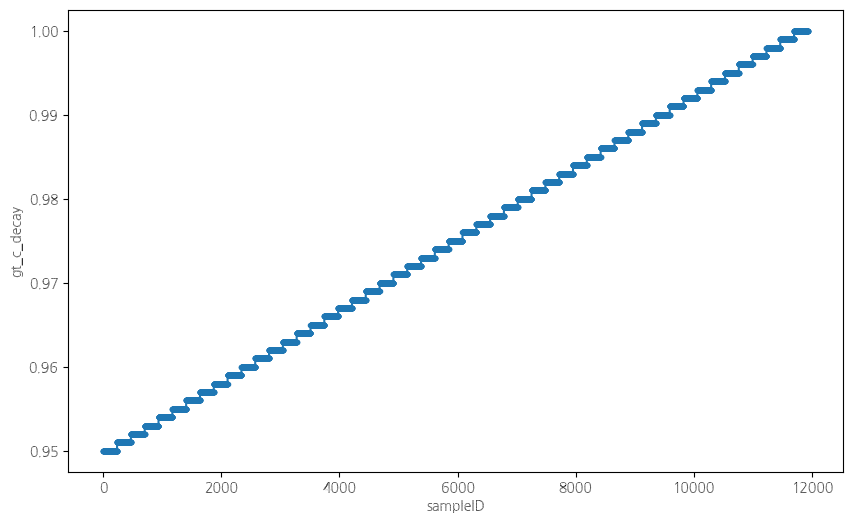

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(naval_df.index, naval_df.gt_c_decay, '.-')
plt.xlabel("sampleID")
plt.ylabel("gt_c_decay")
plt.show()

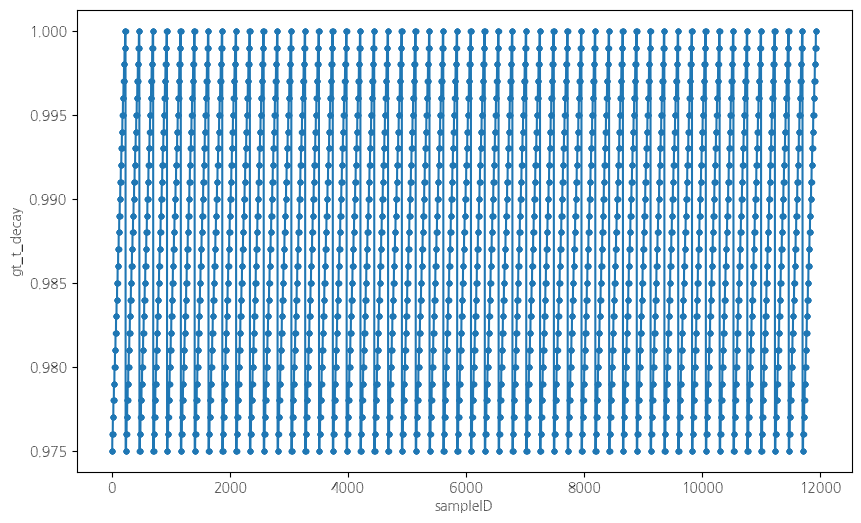

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(naval_df.index, naval_df.gt_t_decay, '.-')
plt.xlabel("sampleID")
plt.ylabel("gt_t_decay")
plt.show()

### 4. Feature 정제

#### 1) 분포 및 이상치 확인

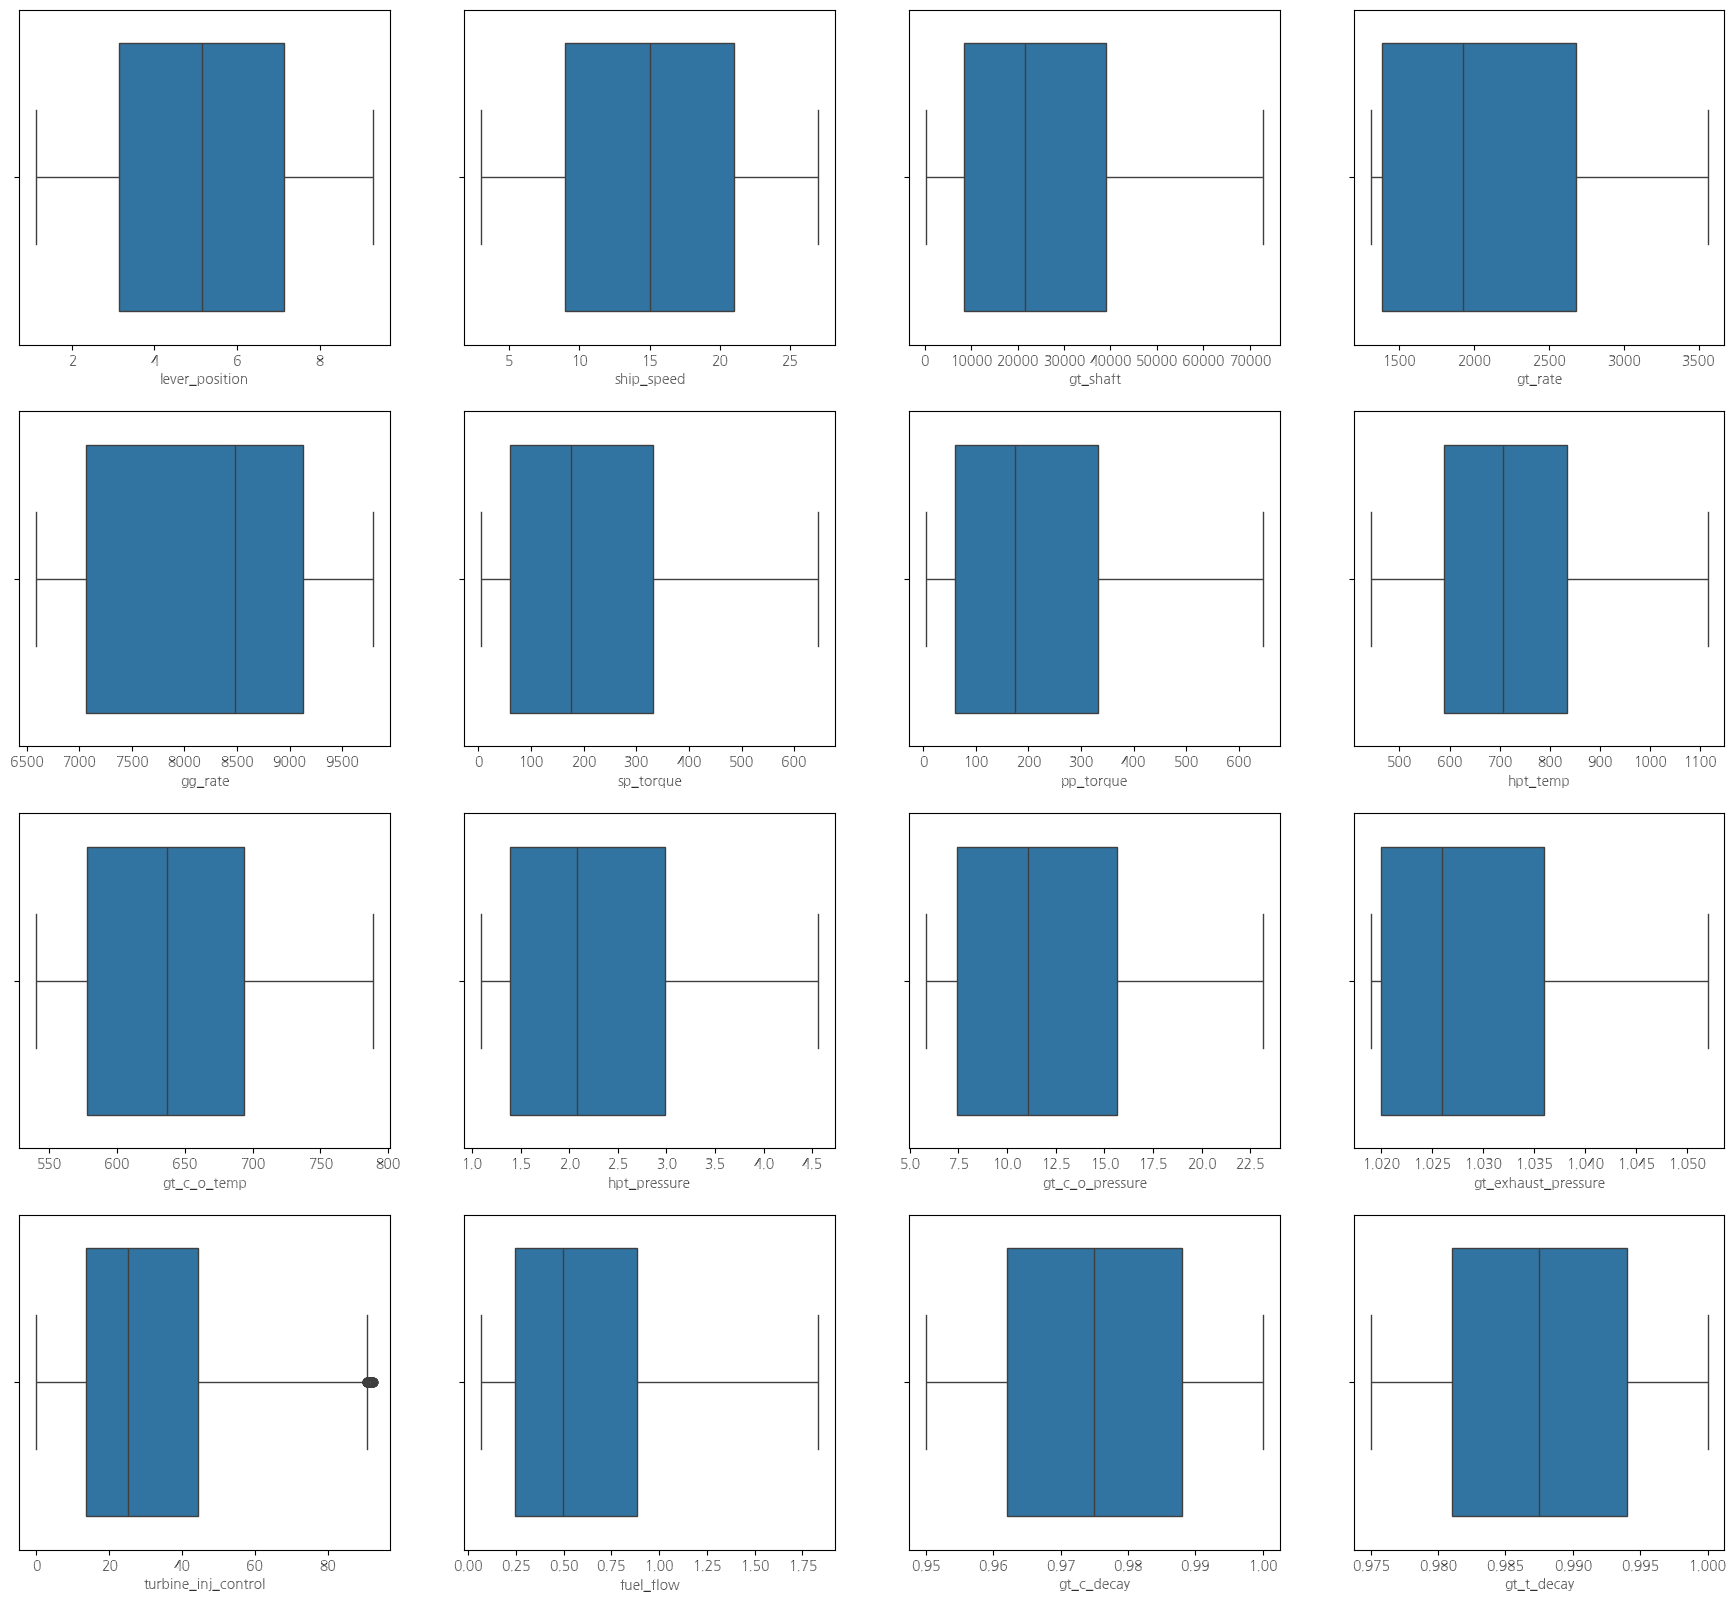

In [19]:
plt.figure(figsize=(22, 20))
icount = 1
for col in naval_df.columns:
  plt.subplot(4, 4, icount)
  sns.boxplot(naval_df[col], orient="h")
  icount = icount + 1
plt.show()

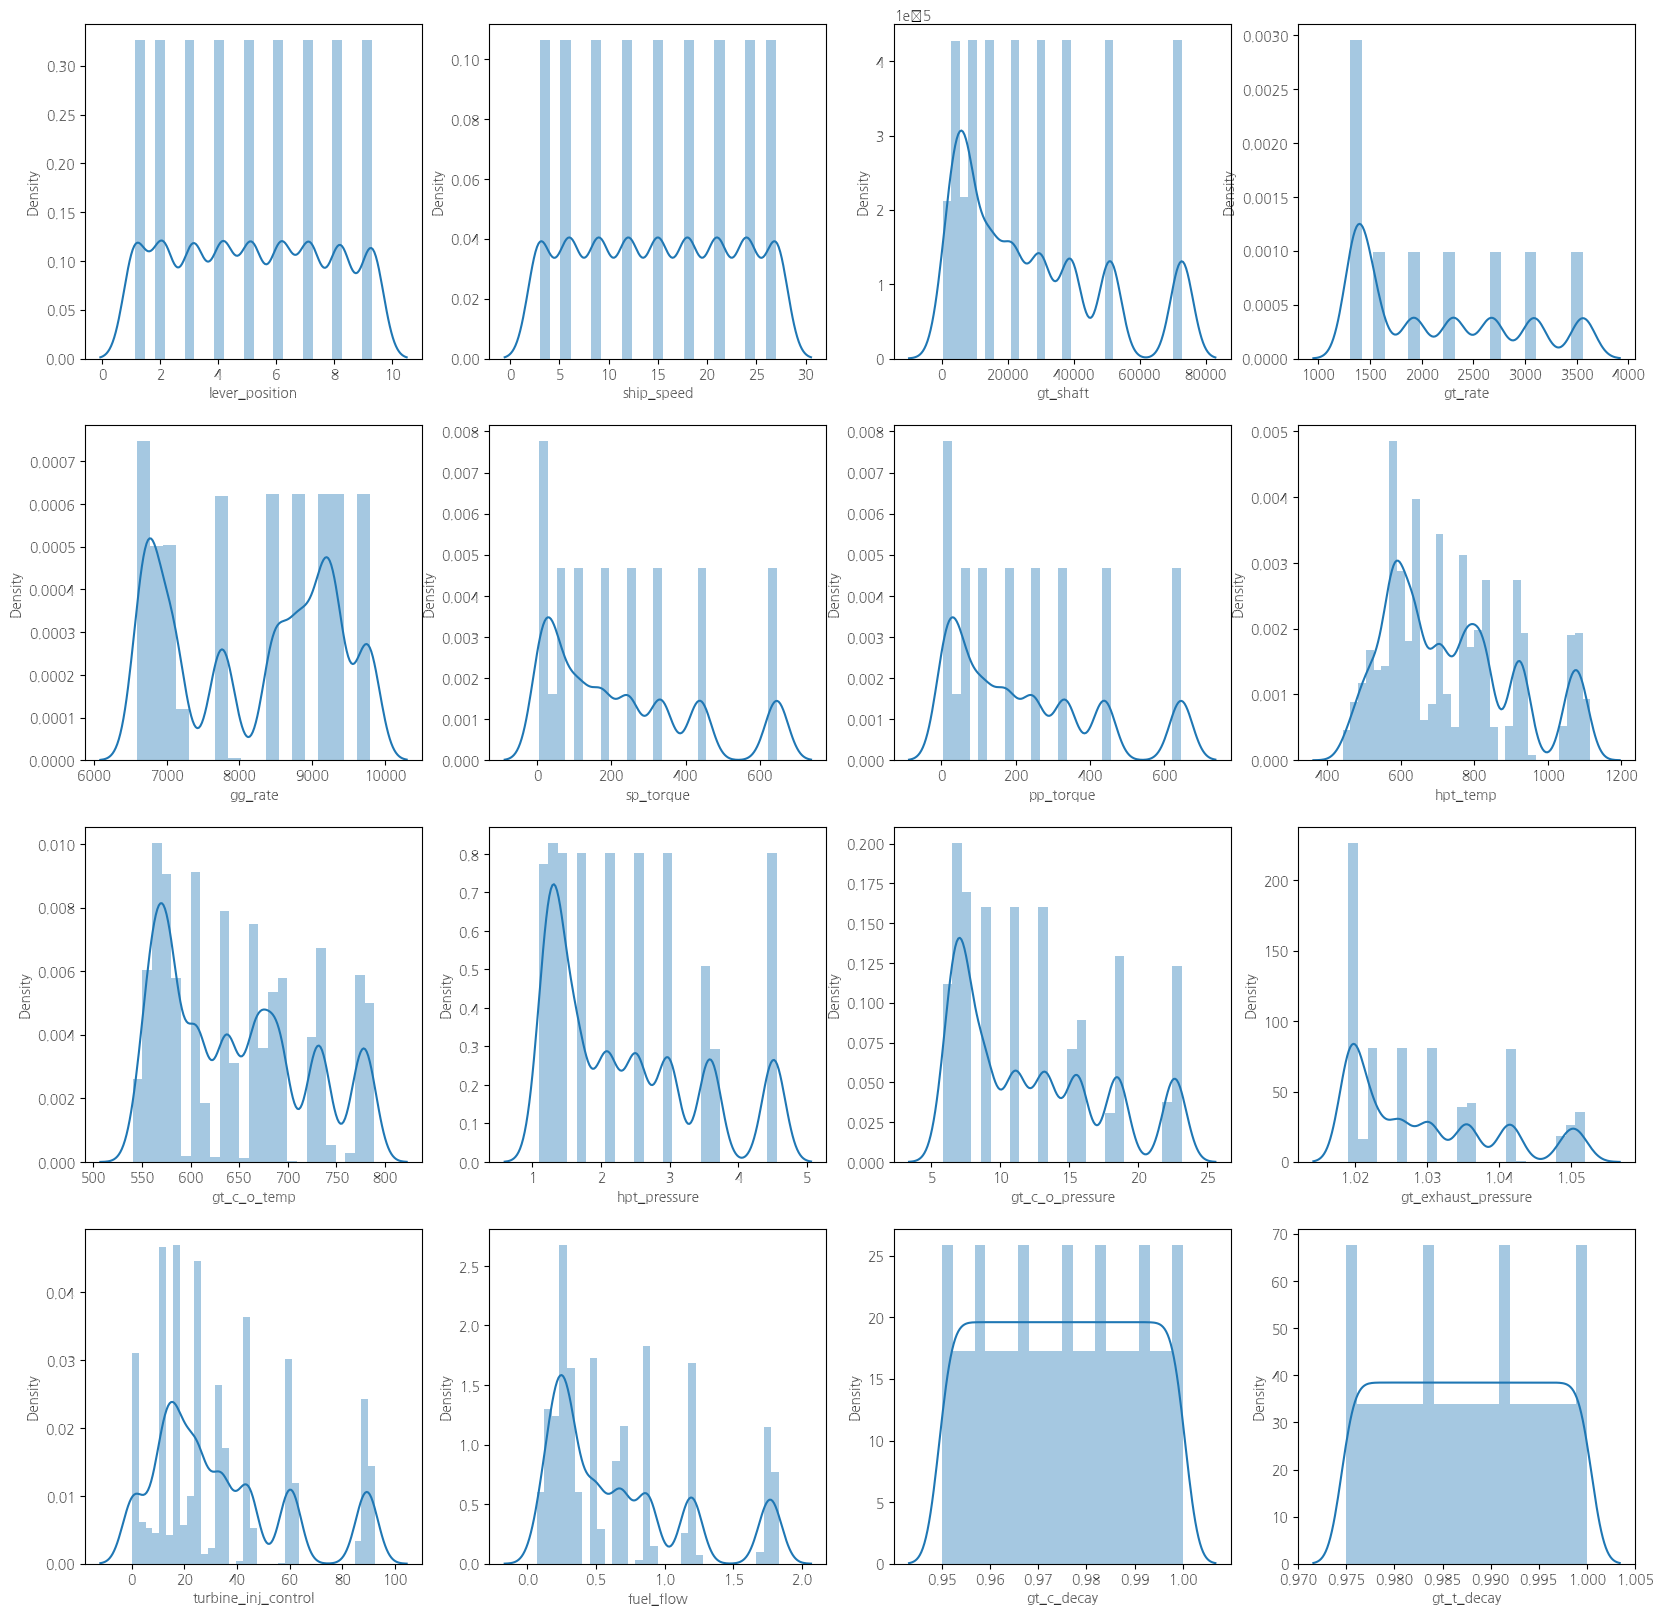

In [20]:
plt.figure(figsize=(20,20))
icount = 1
for col in naval_df.columns:
  plt.subplot(4, 4, icount)
  sns.distplot(naval_df[col])
  icount += 1
plt.show()

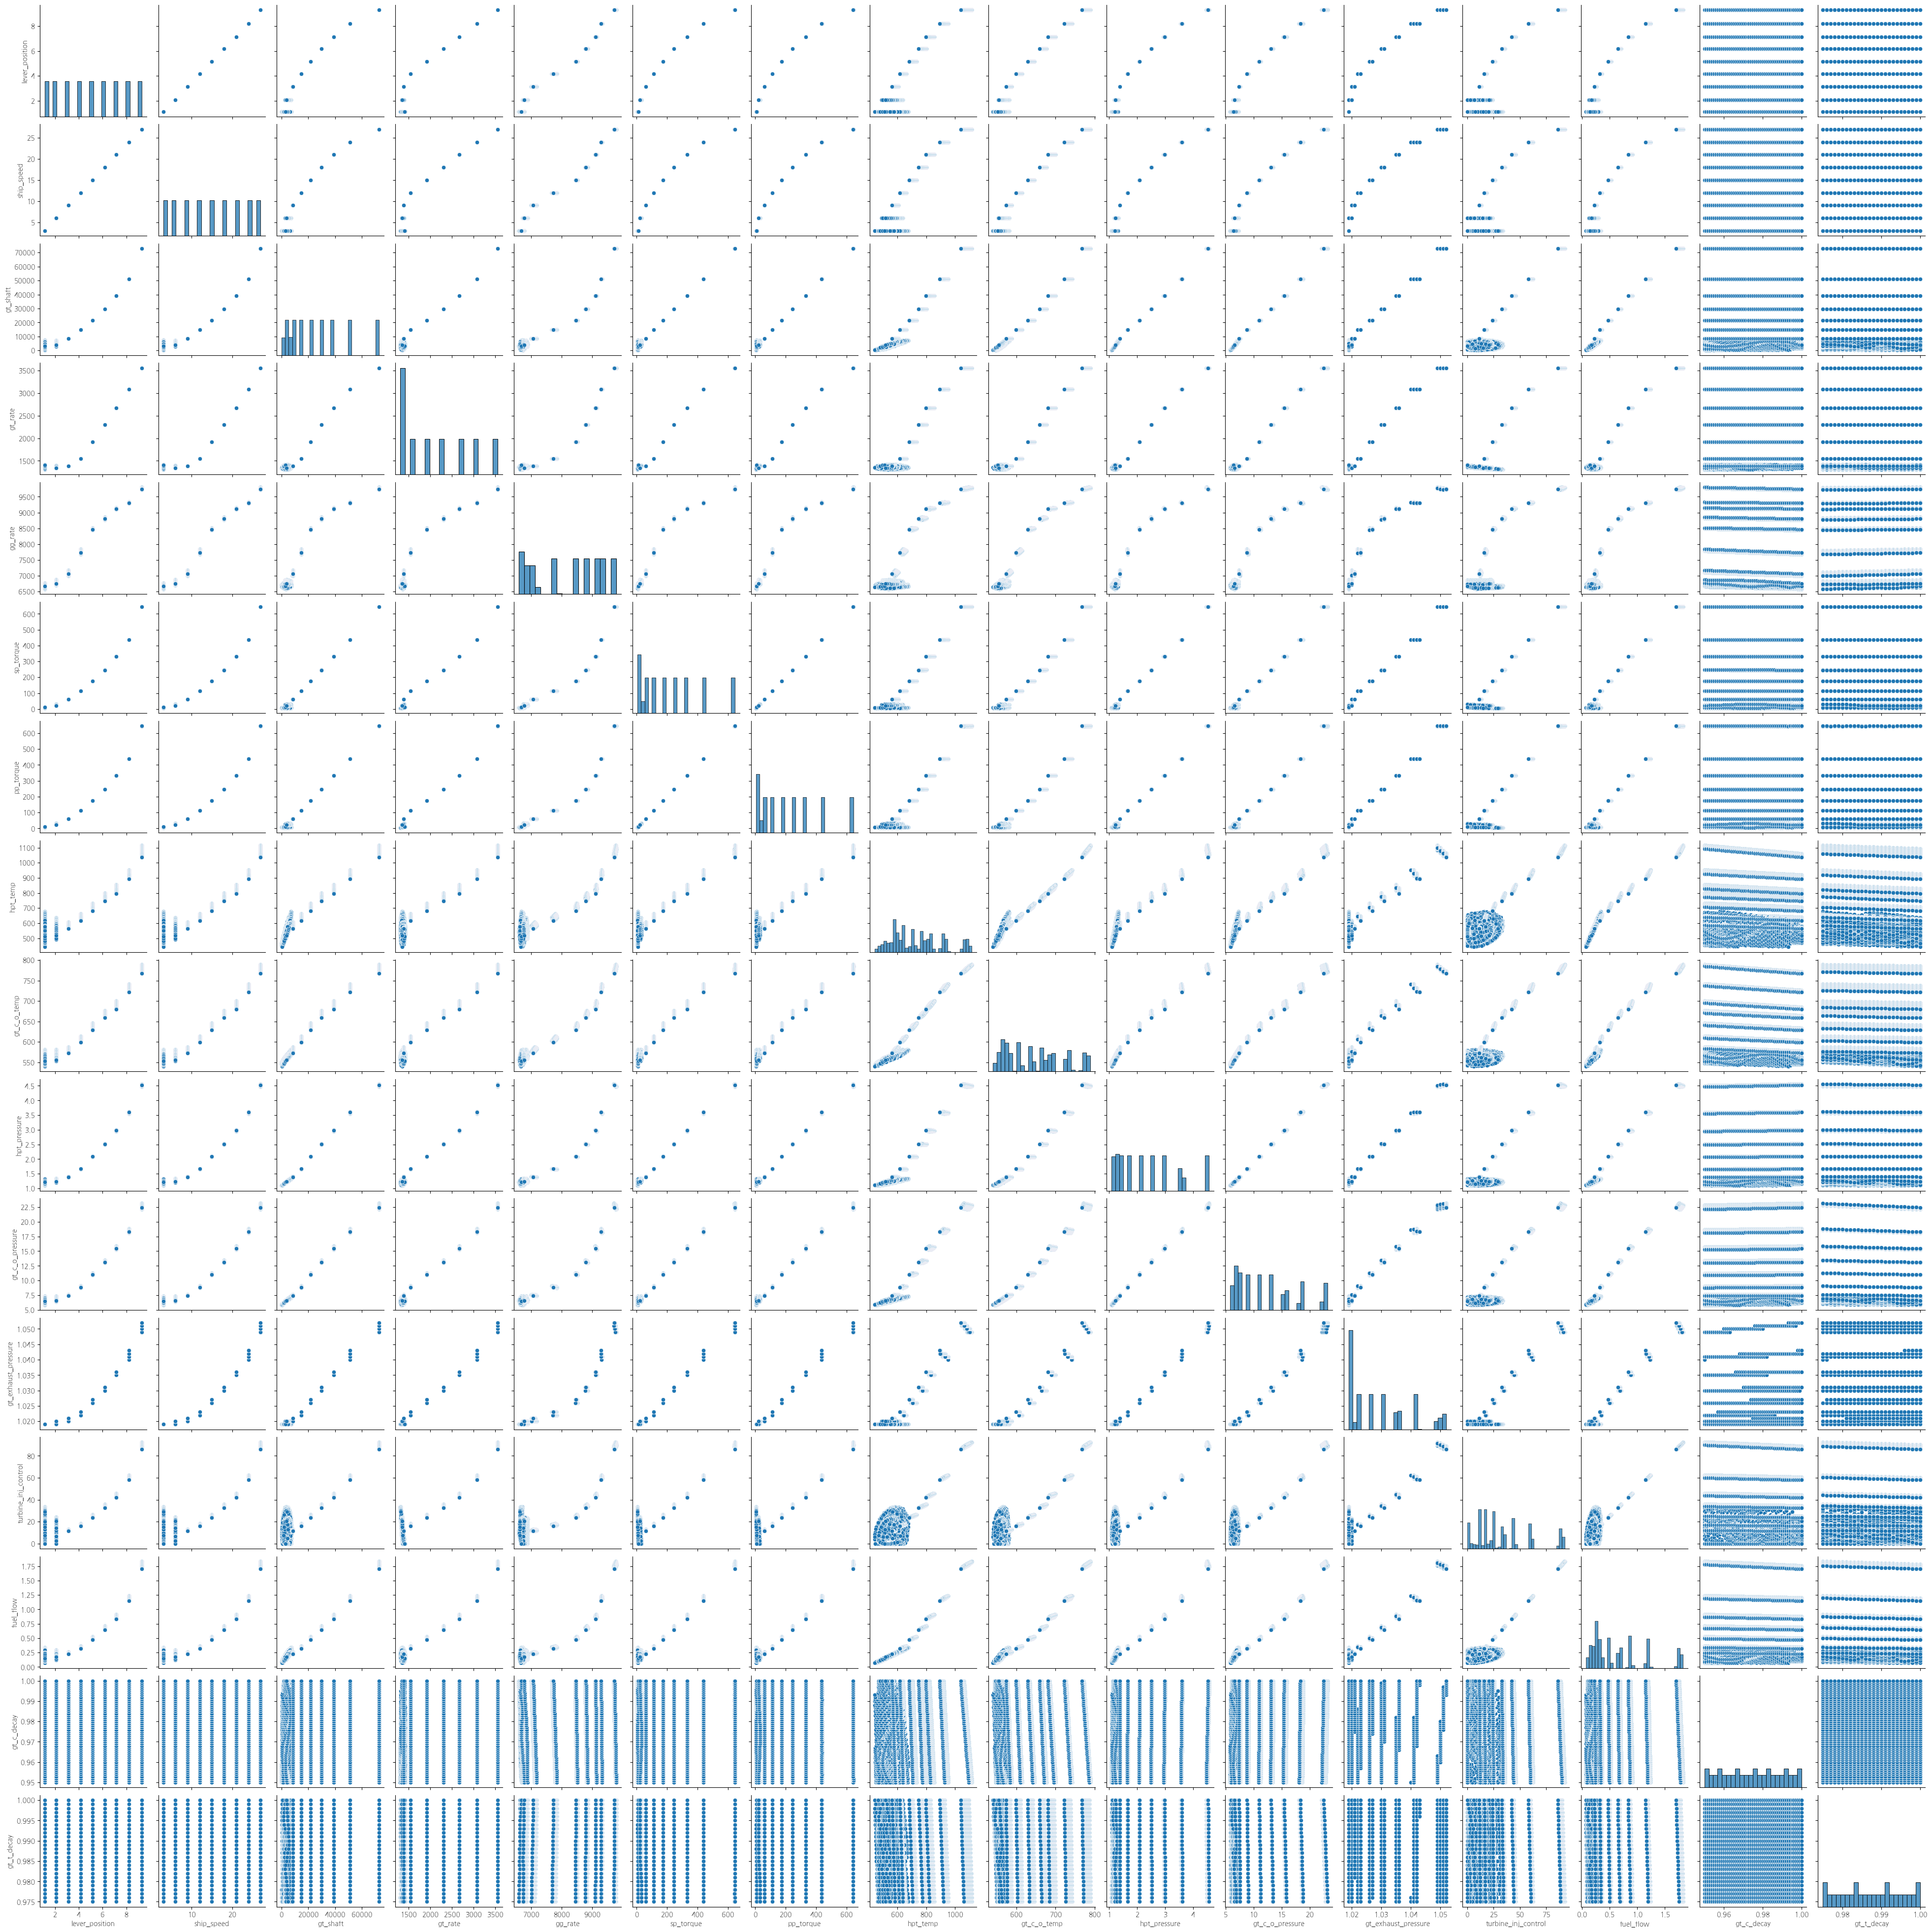

In [21]:
sns.pairplot(naval_df)
plt.show()

#### 2) 상관성 확인

선형성

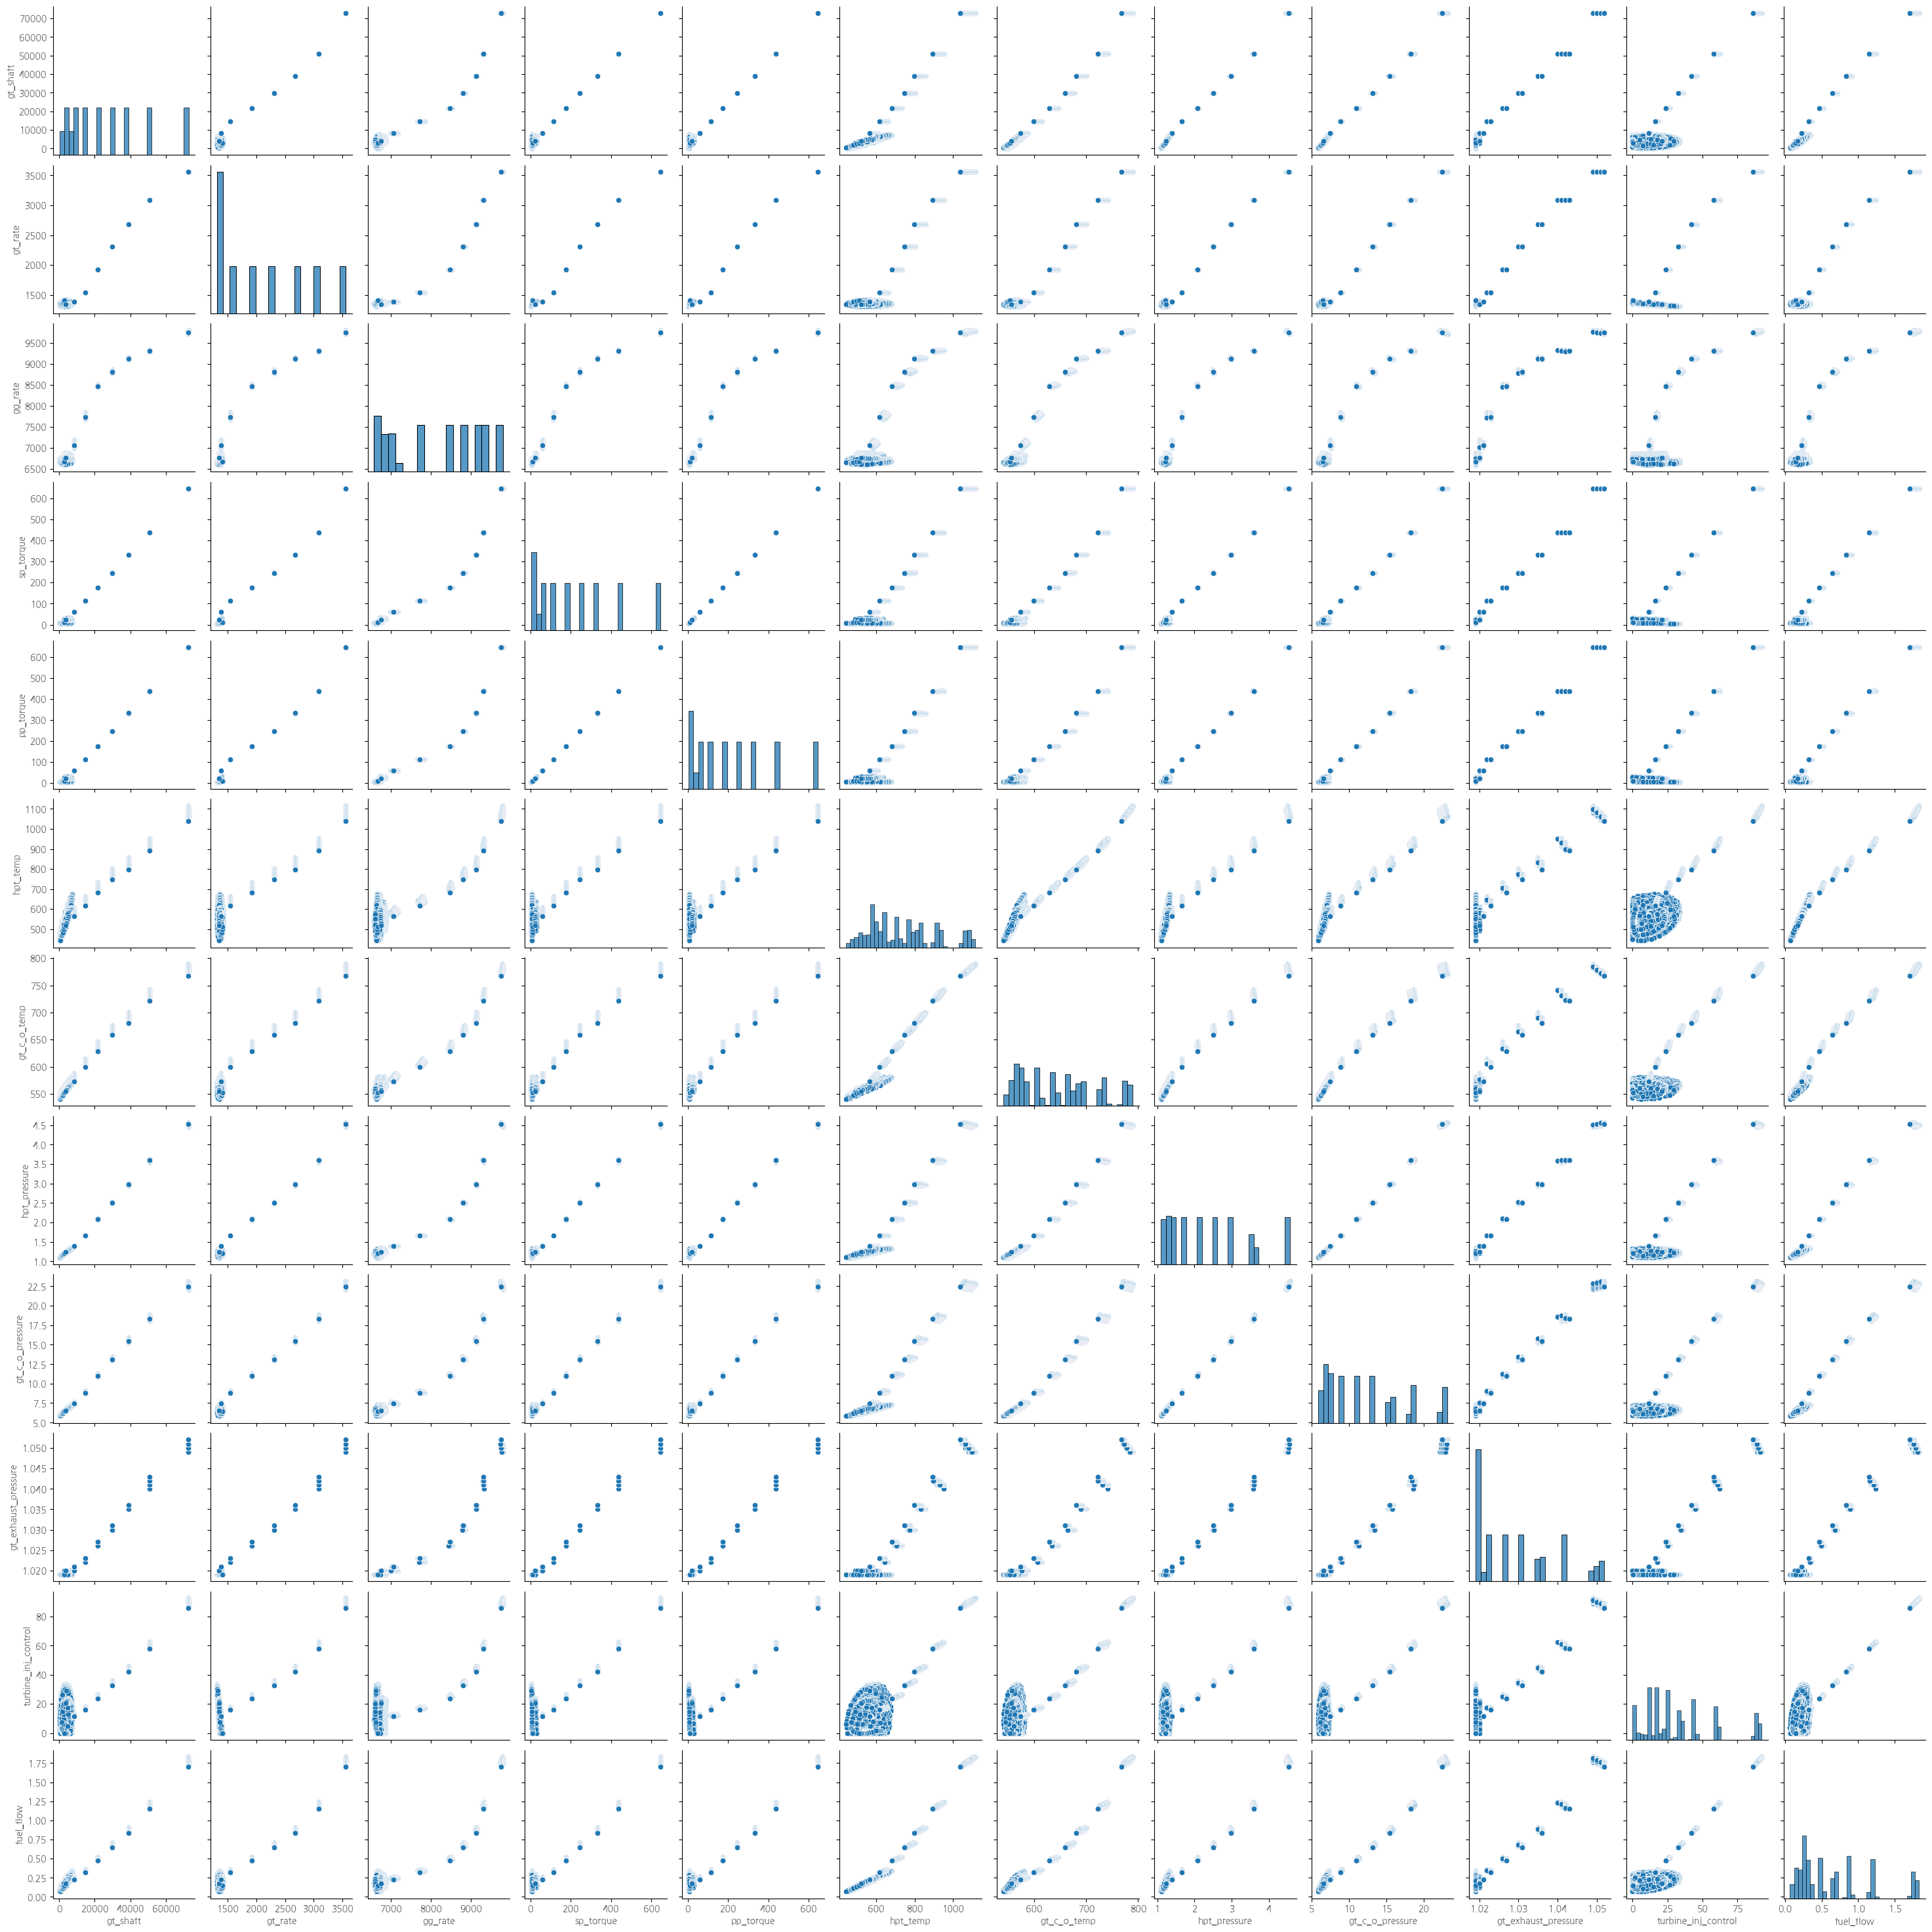

In [22]:
sns.pairplot(naval_df[naval_df.columns[2:-2]])
plt.show()

##### 상관 계수

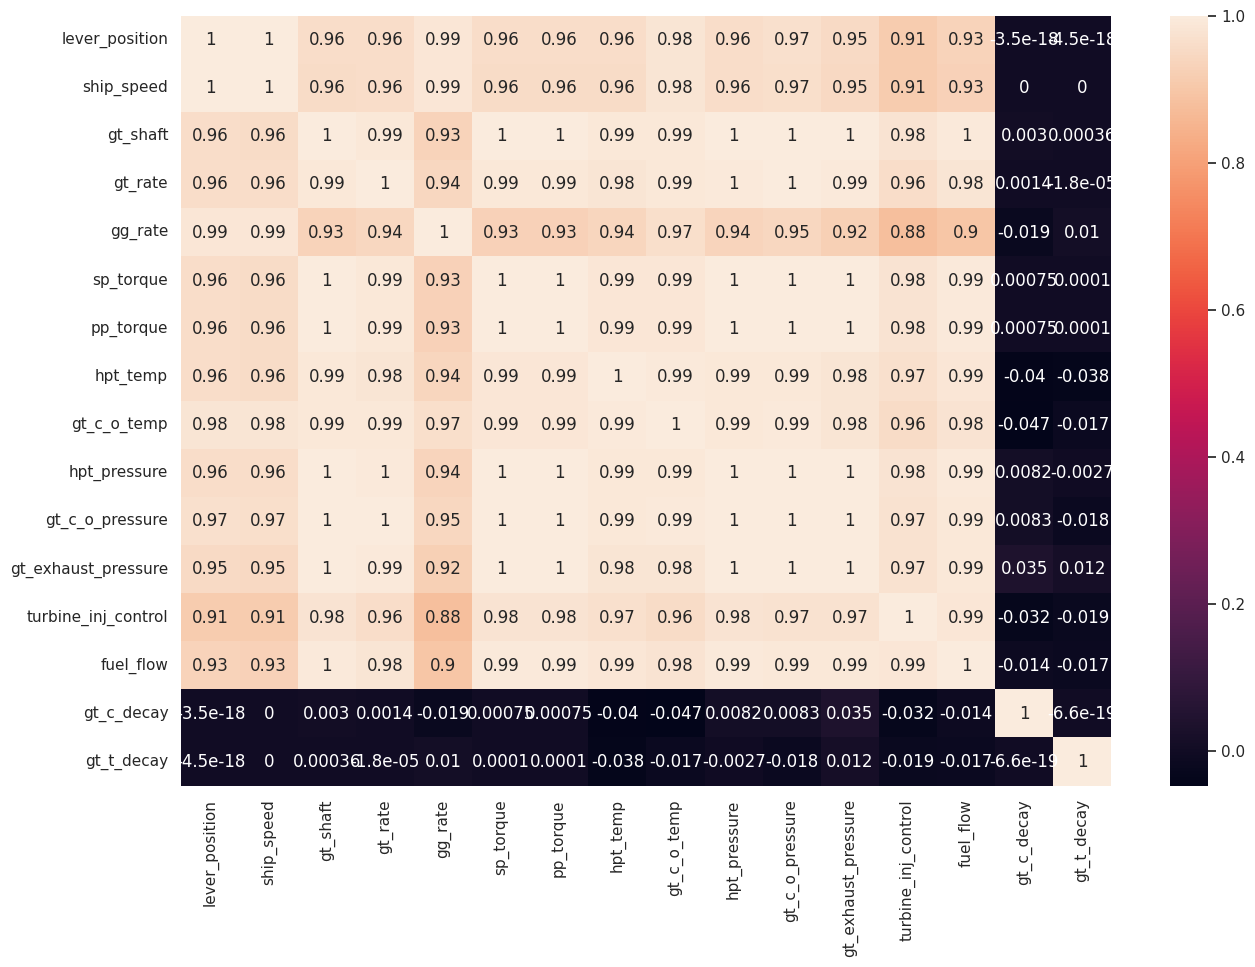

In [23]:
plt.figure(figsize=(15, 10))
cols = naval_df.corr().index
corr_mat = np.corrcoef(naval_df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(corr_mat, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 5. PCA를 활용한 Feature Selection

#### 1) 데이터 준비

In [24]:
np.random.seed(0)

df_train_navel, df_test_navel = train_test_split(naval_df, train_size=0.7, random_state=100)

In [25]:
y_train_c = df_train_navel.pop('gt_c_decay')
y_train_t = df_train_navel.pop('gt_t_decay')
X_train = df_train_navel

y_test_c = df_test_navel.pop('gt_c_decay')
y_test_t = df_test_navel.pop('gt_t_decay')
X_test = df_test_navel

In [26]:
X_train.shape

(8353, 14)

In [27]:
tr_scaled_features = StandardScaler().fit_transform(X_train.values)
X_train = pd.DataFrame(tr_scaled_features, index=X_train.index, columns=X_train.columns)

tt_scaled_features = StandardScaler().fit_transform(X_test.values)
X_test = pd.DataFrame(tt_scaled_features, index=X_test.index, columns=X_test.columns)

#### 2) PCA 적용

> PCA 모델링 순서
- PCA.fit(): 주성분 탐색
- PCA.transform(): 새로운 주성분으로 데이터 변환

In [28]:
pca = PCA(random_state=42)

In [29]:
pca.fit(X_train)

PCA(random_state=42)

<BarContainer object of 14 artists>

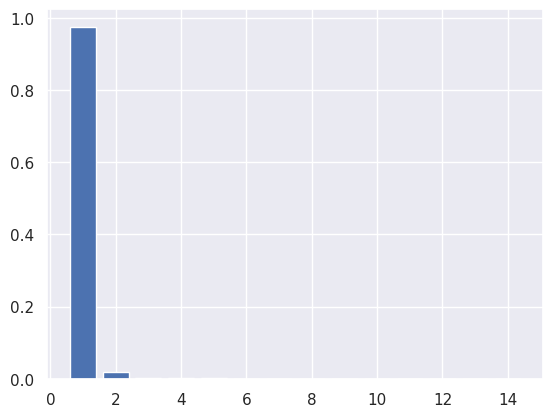

In [30]:
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

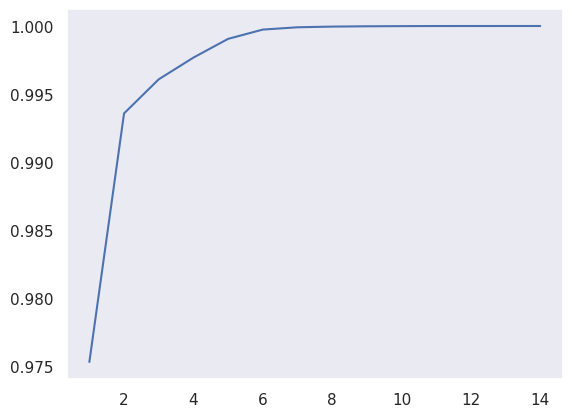

In [31]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(var_cumu) + 1), var_cumu)
plt.grid()

In [32]:
print("no. of Components Variance accounted")
for i in range(2, 8):
  s = ("      " + str(i) + "           " + str(100*var_cumu[i]))
  print(s)

no. of Components Variance accounted
      2           99.6077302196102
      3           99.76745921533721
      4           99.90539613345479
      5           99.97368400447967
      6           99.99060052819466
      7           99.99563788531059


In [33]:
pca.components_

array([[ 2.64204166e-01,  2.63652076e-01,  2.69902735e-01,
         2.68774489e-01,  2.58251061e-01,  2.69543445e-01,
         2.69543445e-01,  2.68376076e-01,  2.69778171e-01,
         2.70114563e-01,  2.70338277e-01,  2.68890088e-01,
         2.62917871e-01,  2.67052903e-01],
       [-4.08284739e-01, -4.26612662e-01,  1.25532599e-01,
         3.67851158e-02, -5.63574495e-01,  1.36664645e-01,
         1.36664645e-01,  5.65749624e-02, -1.02976754e-01,
         1.01982320e-01,  4.94412302e-02,  1.55069649e-01,
         3.64422067e-01,  3.09391600e-01],
       [ 8.30770891e-02,  7.49766227e-02, -4.19840847e-02,
        -4.39271161e-01,  9.91862695e-02, -1.17511089e-01,
        -1.17511089e-01,  3.97594241e-01,  9.58061269e-02,
        -1.68690991e-01, -1.48255451e-01, -3.75717909e-01,
         6.27249921e-01,  5.47405193e-02],
       [-2.92064851e-01, -2.96606947e-01,  3.19730255e-02,
         1.08898605e-01,  1.51017586e-01, -1.49236352e-01,
        -1.49236352e-01,  6.34044002e-01,  2.

In [34]:
# numpy.argmax: 다차원 배열에서 차원에 따라 가장 큰 값의 인덱스들을 반환하는 함수

def getPCAMostImportantFeat(model, initial_feature_names):
  # 총 component 개수
  n_pcs = model.components_.shape[0]

  # 각 component의 중요도 값들 중 가장 큰 값의 인덱스를 반환
  most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

  # 컬럼명 중 위에서 구한 인덱스들에 해당하는 것들만 반환
  most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

  # 컬럼명 중 위에서 구한 인덱스들에 해당하는 것들만 반환
  dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

  df = pd.DataFrame(dic.items())
  return df

In [35]:
pca_grid_df = getPCAMostImportantFeat(pca, X_train.columns)
pca_grid_df

0                    1
0    PC0      gt_c_o_pressure
1    PC1              gg_rate
2    PC2  turbine_inj_control
3    PC3             hpt_temp
4    PC4              gt_rate
5    PC5              gg_rate
6    PC6          gt_c_o_temp
7    PC7          gt_c_o_temp
8    PC8      gt_c_o_pressure
9    PC9             gt_shaft
10  PC10            fuel_flow
11  PC11         hpt_pressure
12  PC12       lever_position
13  PC13            sp_torque

> PCA(n_components=4)

In [36]:
# PCA
pca_4_cpnt = PCA(n_components=4, random_state=42)

In [37]:
# fitting
navel_pca_data = pca_4_cpnt.fit_transform(X_train)

In [38]:
cmp_list = []
[cmp_list.append('PC'+str(i)) for i in range(1, 5)]

[None, None, None, None]

In [39]:
navel_pca_X = pd.DataFrame(navel_pca_data, columns=cmp_list)
navel_pca_X

PC1       PC2       PC3       PC4
0    -4.075176  0.338640 -0.104069 -0.271646
1     0.751580 -0.535183 -0.002603  0.045426
2    -3.218126  0.046751  0.082406 -0.084042
3     0.755436 -0.573194  0.066547  0.101727
4    -2.109785 -0.320491  0.110992 -0.066861
...        ...       ...       ...       ...
8348  7.191667  0.783968  0.232537  0.113531
8349  4.222719 -0.069220  0.015471  0.096768
8350 -3.254917  0.070804  0.052302 -0.124266
8351  2.211526 -0.468811 -0.162784 -0.059197
8352  2.265976 -0.444182 -0.054165  0.023447

[8353 rows x 4 columns]

In [40]:
navel_pca_X.reset_index(drop=True, inplace=True)

In [41]:
# Transform
navel_pca_data_test = pca_4_cpnt.transform(X_test)
navel_pca_test_X = pd.DataFrame(navel_pca_data_test, columns=cmp_list)
navel_pca_test_X

PC1       PC2       PC3       PC4
0    -2.156559 -0.313887  0.102346 -0.072833
1     7.145500  0.817095 -0.103651 -0.132883
2    -4.009398  0.307652 -0.358082  0.137437
3    -2.203507 -0.302685  0.060052 -0.125031
4    -4.426391  0.874049  0.152101 -0.382087
...        ...       ...       ...       ...
3576  7.180030  0.809197  0.024790 -0.041241
3577  2.241601 -0.446451 -0.131713 -0.031622
3578  0.750904 -0.565331  0.078595  0.115207
3579 -4.384748  0.574880 -0.393005  0.318642
3580  7.154916  0.820572 -0.035112 -0.092682

[3581 rows x 4 columns]

## 다양한 Regressor를 활용한 모델 생성과 Hypertuning

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

### 1. 모델 준비

In [43]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'XGBRegressor': XGBRegressor()
}

params = {
    'LinearRegression': [{'fit_intercept': [True, False], 'positive': [True, False], 'copy_X': [True, False]}],
    'RandomForestRegressor': [{'n_estimators': [50, 60, 80]}],
    'KNeighborsRegressor': [{'n_neighbors': [2, 3, 4, 5, 6]}],
    'DecisionTreeRegressor': [{'max_depth': [2, 4, 6, 8, 10, 12]}],
    'BaggingRegressor': [{'base_estimator': [None, GradientBoostingRegressor(), KNeighborsRegressor()], 'n_estimators': [20, 50, 100]}],
    'XGBRegressor': [{'n_estimators': [50, 500]}],

}

In [44]:
pca_grid_df.head()

0                    1
0  PC0      gt_c_o_pressure
1  PC1              gg_rate
2  PC2  turbine_inj_control
3  PC3             hpt_temp
4  PC4              gt_rate

In [45]:
x_pca_cols = pca_grid_df.iloc[:, 1].tolist()

### 2. 모델 생성

> 하나의 함수로 여러 Regressor들에 대해 GridSearchCV 적용

In [49]:
important_features_list = []
plt.figure(figsize=(20, 12))

def runregressors(X_train, Y_train, X_test, Y_test):
  i_count = 0
  # 총 3*2, 6개의 그래프를 생성
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

  # 각 평가지표를 저장할 변수를 생성
  result_name = []
  result_summary1 = []
  result_mae = []
  result_mse = []
  result_exp_var = []
  result_r2_score = []
  result_ac_score = []

  for name in models.keys():

    # estimator와 parameter를 가져온다
    est = models[name]
    est_params = params[name]

    """
    최적 파라미터 탐색
    """
    # GridSearchCV 생성하여 fitting (cv=5)
    gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
    gscv.fit(X_train, Y_train)

    # 가장 좋은 성능 지표를 저장한다
    msg1 = str(gscv.best_estimator_)
    result_summary1.append(msg1)
    result_name.append(name)

    # 베스트 모델로 predict
    y_pred = gscv.predict(X_test)

    """
    모델 평가
    """
    ascore = gscv.best_estimator_.score(X_test, Y_test)

    # explained_variance_score 적용
    score = explained_variance_score(Y_test, y_pred)

    # mean_absolute_error 적용
    mae = mean_absolute_error(Y_test, y_pred)

    # mean_squared_error 적용
    mse = mean_squared_error(Y_test, y_pred)

    # r2_score 적용
    r2 = r2_score(Y_test, y_pred)

    msg2 = "%s: %f (%f)"%(name, score*100, mae*100)
    print(msg2)

    result_mse.append(mse)
    result_mae.append(mae)
    result_exp_var.append(score)
    result_r2_score.append(r2)
    result_ac_score.append(ascore)

    if name == "LinearRegression":
      # coefficient 가져오기
      important_features = pd.Series(gscv.best_estimator_.coef_, index=x_pca_cols[:4])

    elif name == "KNeighborsRegressor":
      # permutation_importance 적용
      results = permutation_importance(gscv.best_estimator_, X_train, Y_train, scoring="neg_mean_squared_error")
      # importance
      important_features = pd.Series(results.importances_mean, index=x_pca_cols[:4])

    elif name == "BaggingRegressor":
      feature_importances = np.mean([tree.feature_importances_ for tree in gscv.best_estimator_], axis=0)
      important_features = pd.Series(feature_importances, index=x_pca_cols[:4])

    else:
      important_features = pd.Series(gscv.best_estimator_.feature_importances_, index=x_pca_cols[:4])
    important_features_list.append(important_features)

    col = i_count%2
    row = i_count//2
    ax[row][col].scatter(Y_test, y_pred)
    ax[row][col].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
    ax[row][col].set_xlabel('실제값')
    ax[row][col].set_ylabel('예측값')
    ax[row][col].set_title(msg2)
    i_count += 1

  plt.show()

  result_summary_list = pd.DataFrame({'name': result_name,
                                      'best_estimator': result_summary1,
                                      'R2': result_r2_score,
                                      'MAE': result_mae,
                                      'MSE': result_mse,
                                      'explained variance score': result_exp_var,
                                      'accuracy': result_ac_score})
  return result_summary_list

<Figure size 2000x1200 with 0 Axes>

### 컴프레서 부식 예측

LinearRegression: 15.677569 (1.151880)
RandomForestRegressor: 87.283159 (0.482728)
KNeighborsRegressor: 92.145916 (0.471307)
DecisionTreeRegressor: 69.153311 (0.583486)
BaggingRegressor: 87.940941 (0.472559)
XGBRegressor: 90.808314 (0.467427)


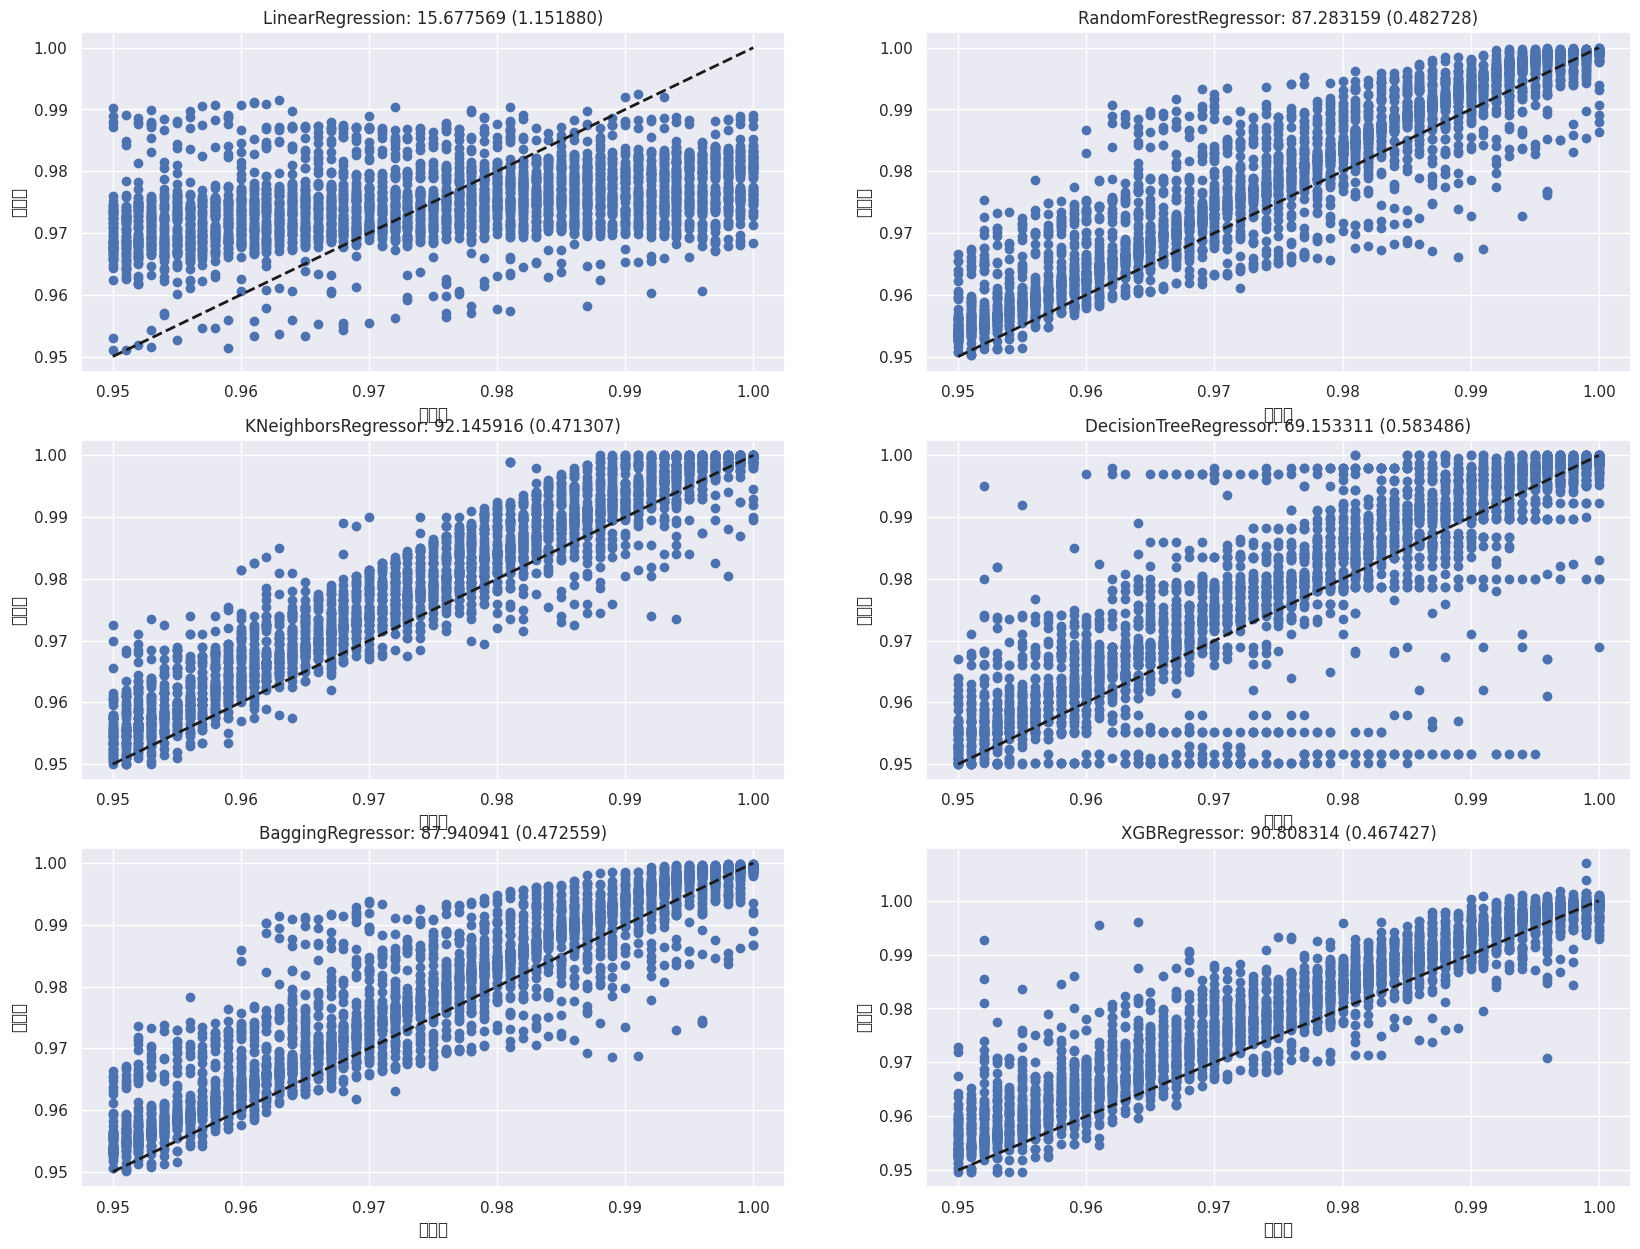

In [51]:
result_summary_list = runregressors(navel_pca_X, y_train_c, navel_pca_test_X, y_test_c)

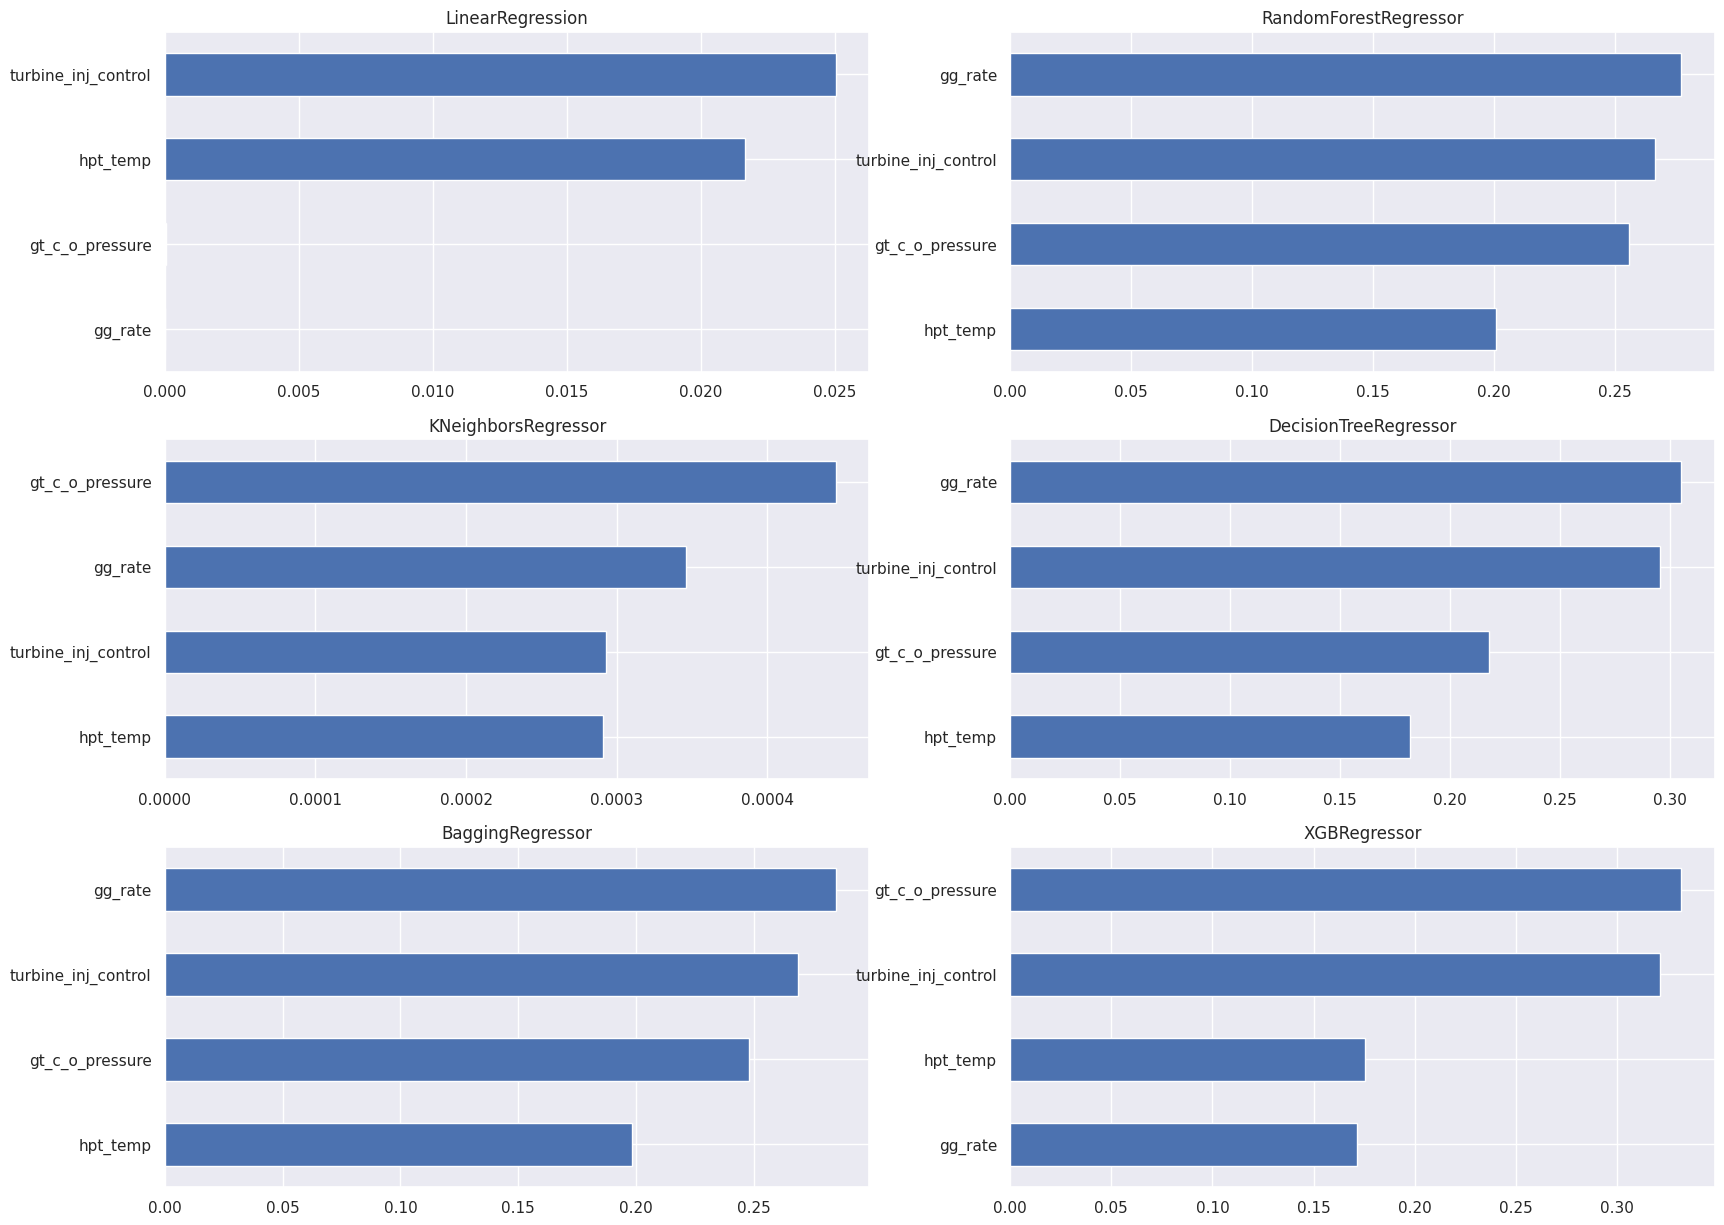

In [53]:
for i in range(0, 4):
  important_features_list[0][i] = abs(important_features_list[0][i])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
i_count = 0
nm = result_summary_list.name.to_list()
for imp_fea in important_features_list:
  col = i_count%2
  row = i_count//2
  imp_fea.sort_values().plot(kind='barh', ax=ax[row][col])
  ax[row][col].set_title(nm[i_count])
  i_count += 1

plt.show()

In [54]:
result_summary_list

name                                     best_estimator  \
0       LinearRegression                                 LinearRegression()   
1  RandomForestRegressor             RandomForestRegressor(n_estimators=50)   
2    KNeighborsRegressor                 KNeighborsRegressor(n_neighbors=2)   
3  DecisionTreeRegressor                DecisionTreeRegressor(max_depth=12)   
4       BaggingRegressor  BaggingRegressor(base_estimator=None, n_estima...   
5           XGBRegressor  XGBRegressor(base_score=None, booster=None, ca...   

         R2       MAE       MSE  explained variance score  accuracy  
0  0.156181  0.011519  0.000185                  0.156776  0.156181  
1  0.812927  0.004827  0.000041                  0.872832  0.812927  
2  0.843396  0.004713  0.000034                  0.921459  0.843396  
3  0.668148  0.005835  0.000073                  0.691533  0.668148  
4  0.817404  0.004726  0.000040                  0.879409  0.817404  
5  0.833745  0.004674  0.000036                  0.908083  0.833745

### 가스터빈 부식 예측

LinearRegression: 5.712088 (0.622515)
RandomForestRegressor: 79.402952 (0.387576)
KNeighborsRegressor: 76.264028 (0.372019)
DecisionTreeRegressor: 67.877797 (0.408979)
BaggingRegressor: 79.459164 (0.387290)
XGBRegressor: 77.837344 (0.384680)


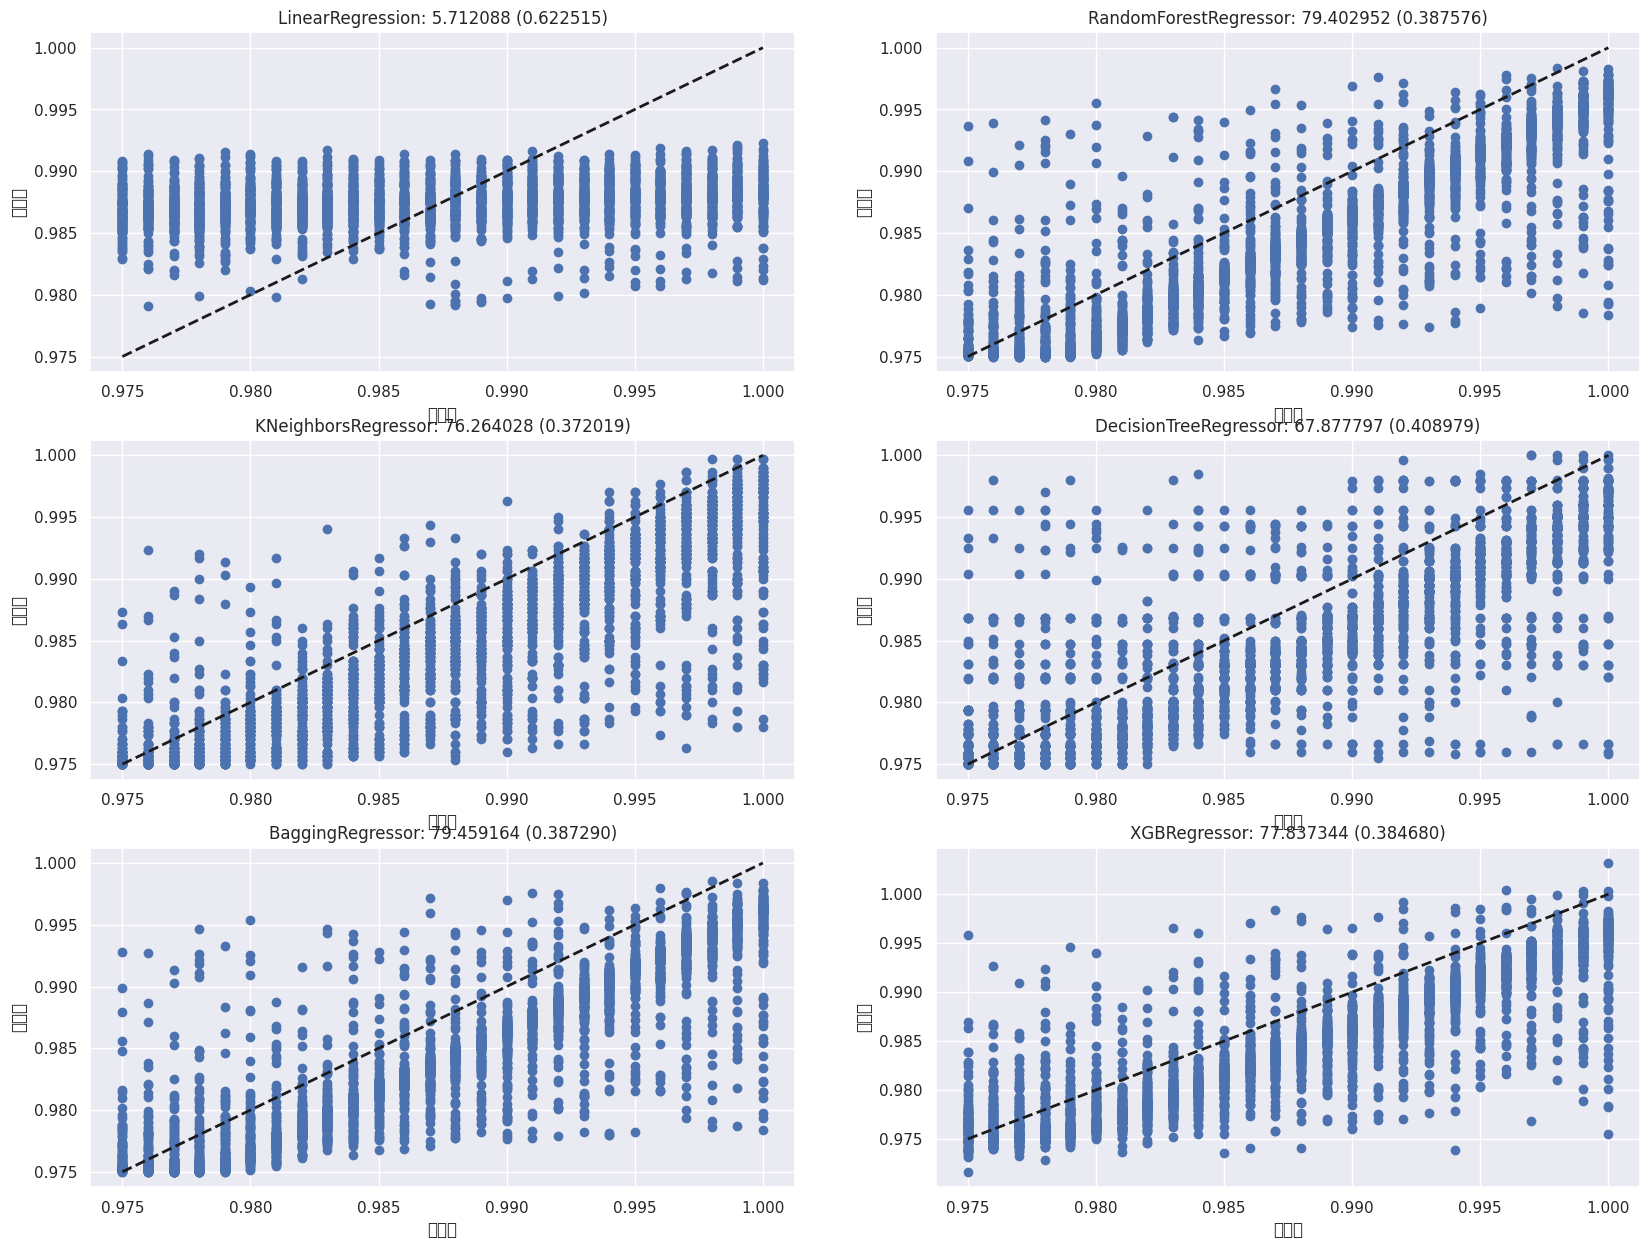

In [55]:
result_summary_list_t = runregressors(navel_pca_X, y_train_t, navel_pca_test_X, y_test_t)

In [56]:
result_summary_list_t

name                                     best_estimator  \
0       LinearRegression                                 LinearRegression()   
1  RandomForestRegressor             RandomForestRegressor(n_estimators=60)   
2    KNeighborsRegressor                 KNeighborsRegressor(n_neighbors=3)   
3  DecisionTreeRegressor                DecisionTreeRegressor(max_depth=12)   
4       BaggingRegressor  BaggingRegressor(base_estimator=None, n_estima...   
5           XGBRegressor  XGBRegressor(base_score=None, booster=None, ca...   

         R2       MAE       MSE  explained variance score  accuracy  
0  0.057081  0.006225  0.000053                  0.057121  0.057081  
1  0.608998  0.003876  0.000022                  0.794030  0.608998  
2  0.570676  0.003720  0.000024                  0.762640  0.570676  
3  0.542062  0.004090  0.000026                  0.678778  0.542062  
4  0.610103  0.003873  0.000022                  0.794592  0.610103  
5  0.613360  0.003847  0.000022                  0.778373  0.613360